**<h1 align="center">Text Mining Project</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

**Project goal:** Build an NLP classifier that labels tweets as:

Bearish (0)

Bullish (1)

Neutral (2)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer

# Import DistilBERT Tools
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm


# Imports for models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import resample
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from datasets import Dataset, ClassLabel


# Loading the data

In [2]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

# EDA

## Data Quality

- The only values in label are 0,1 and 2
- There are no missing values on both datasets;
- There are no duplicates on both datasets;

In [3]:
df_train.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [5]:
df_test.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


### Check for wrong labels

In [6]:
# Check that labels are only 0,1, or 2
df_train['label'].unique()

array([0, 1, 2])

### Check for missing values

In [7]:
# check for missing values
print("Missing values in train dataset:")
print(df_train.isnull().sum())
print("\nMissing values in test dataset:")
print(df_test.isnull().sum())

Missing values in train dataset:
text     0
label    0
dtype: int64

Missing values in test dataset:
id      0
text    0
dtype: int64


### check for duplicates

In [8]:
# check for duplicates
print("Duplicates in train dataset:", df_train.duplicated().sum())
print("Duplicates in test dataset:", df_test.duplicated().sum())

Duplicates in train dataset: 0
Duplicates in test dataset: 0


## Data Exploration

The average sentiment label in the training dataset is ~1.50, which suggests a **slight tendency toward positive or neutral sentiment**. Since the labels are categorical — Bearish (0), Bullish (1), and Neutral (2) — this average doesn’t map to a real sentiment but indicates that Bearish tweets are less frequent compared to Bullish and Neutral ones

### Label Distribution

In [9]:
label_counts = df_train['label'].value_counts().sort_index()
label_percent = round(df_train['label'].value_counts(normalize=True) * 100,1)

In [10]:
# get value counts for label
print("Label distribution in train dataset:")
print(label_counts)

# get value counts for label in percentage
print("Label distribution in train dataset (percentage):")
print(label_percent)

Label distribution in train dataset:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64
Label distribution in train dataset (percentage):
label
2    64.7
1    20.2
0    15.1
Name: proportion, dtype: float64


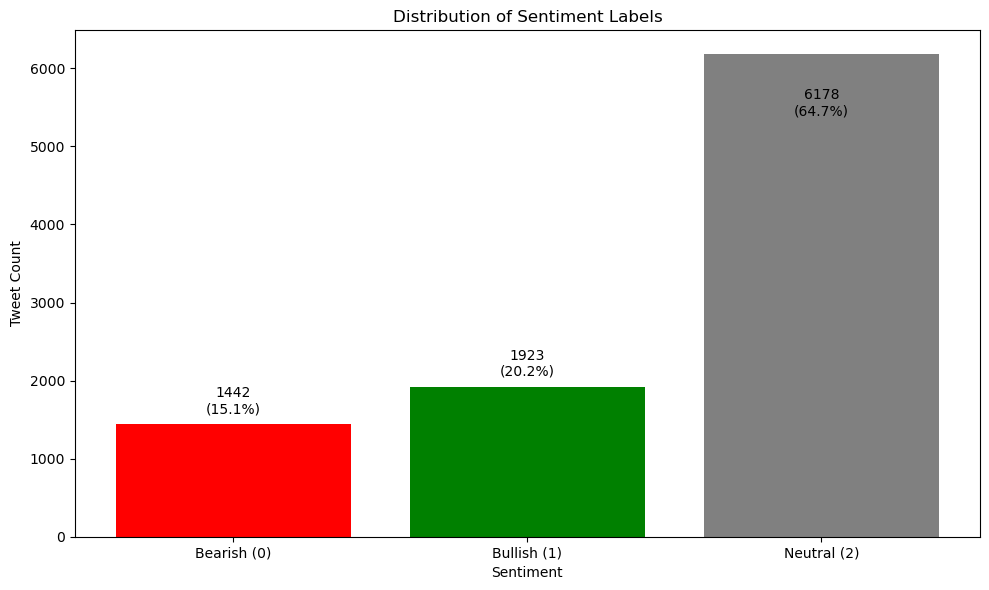

In [11]:
# Plot
colors = ['red', 'green', 'gray']
labels = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']

plt.figure(figsize=(10,6))
bars = plt.bar(labels, label_counts, color=colors)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')

# Annotate values
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = label_percent[i]
    
    # Adjust offset depending on bar height
    offset = -0.07 * height if height > 5000 else 100
    va = 'top' if height > 5000 else 'bottom'
    
    plt.text(bar.get_x() + bar.get_width()/2,
             height + offset,
             f'{int(height)}\n({pct}%)',
             ha='center', va=va, fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [12]:
# get the label mean
label_mean = df_train['label'].mean()
print(f'Our training set has a mean of {round(label_mean,1)}')

Our training set has a mean of 1.5


### Text Exploration

#### Text Length Analysis

`Key Findings` <br>

The average tweet length in the dataset is approximately 86 characters and 12 words.

Most tweets are fairly short, with 75% under 120 characters and under 15 words.

The shortest tweet has just 2 characters, and the longest reaches 190 characters or 32 words.

This confirms that the dataset fits the typical tweet format and is well-suited for models like RNNs, LSTMs, or Transformers that handle short text.

These findings will also help in setting padding/truncation parameters during preprocessing (e.g., max_len = 32 or max_len = 40 to be safe).



In [13]:
df_train['char_count'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().apply(len)

df_train[['char_count', 'word_count']].describe()

,char_count,word_count
count,9543.000000,9543.000000
mean,85.816934,12.178351
std,35.097229,4.665599
min,2.000000,1.000000
25%,58.000000,9.000000
50%,79.000000,11.000000
75%,120.000000,15.000000
max,190.000000,32.000000


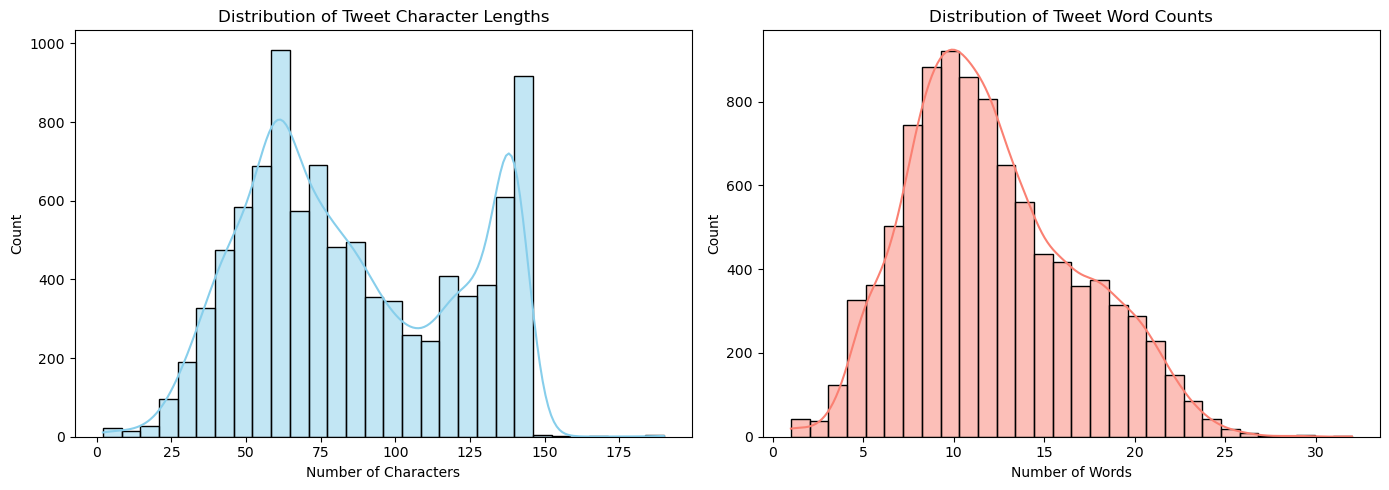

In [14]:
# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count
sns.histplot(df_train['char_count'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Tweet Character Lengths')
axes[0].set_xlabel('Number of Characters')

# Word count
sns.histplot(df_train['word_count'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Tweet Word Counts')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

#### Common Words per Sentiment Class (WordCloud)

`What the Word Clouds Reveal:` <br>

- Bearish Tweets often contain negatively charged words such as **cut, misses, lower, decline, and crisis-related terms like coronavirus, oil, and China**. This suggests a focus on economic threats, losses, and negative forecasts.

- Bullish Tweets are characterized by positive performance indicators such as **beat, rise, gain, target raised, and higher**. Words like buy and soar indicate strong investor confidence.

- Neutral Tweets tend to include objective and informative language, e.g., **update, conference call, results, CEO, dividend, MarketScreener**. These tweets appear more factual and less emotionally driven.


> The repeated appearance of noise tokens like **https, co, and rt** in all classes confirms the need for text cleaning before model training.



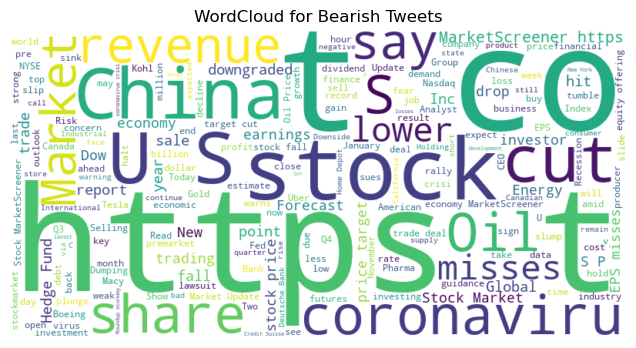

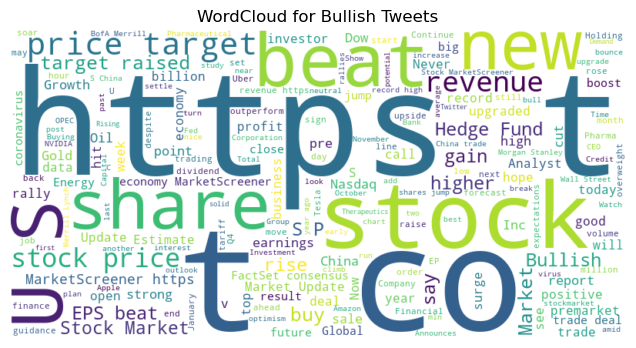

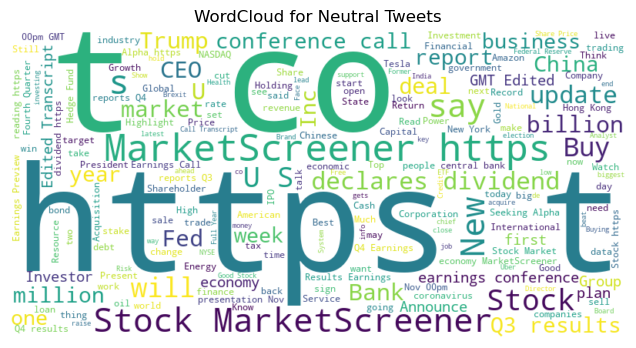

In [15]:
for label, name in zip([0, 1, 2], ['Bearish', 'Bullish', 'Neutral']):
    text = ' '.join(df_train[df_train['label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {name} Tweets')
    plt.show()

#### Top N-grams

By extracting the most frequent bigrams (2-word sequences) in the dataset, we identify recurring phrase patterns that reflect both the contextual structure of financial tweets and potential informative features for classification.

**A large portion of frequent bigrams are news-source references**, such as:

marketscreener https; <br>
stock marketscreener;<br>
economy marketscreener;<br>
stock https.

These likely come from automatic link-sharing tweets or syndicated content.

**Other bigrams are domain-specific and sentiment-relevant**, such as:

hedge funds;<br>
price target;<br>
stock market;<br>
stock price<br>
q3 results;<br>
earnings conference;

which are informative but likely neutral in tone.

In [16]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_train['text'])
sum_words = X.sum(axis=0)

# Most common bigrams
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

for word, freq in words_freq:
    print(f"{word}: {freq}")

marketscreener https: 478
stock marketscreener: 315
hedge funds: 163
price target: 141
stock market: 137
economy marketscreener: 137
stock price: 109
q3 results: 99
earnings conference: 90
stock https: 89


# Corpus split

To prepare the dataset for model training and validation, we performed an 80/20 split on the labeled data. This means that **80% of the tweets were used for training, while 20% were held out for validation purposes**. <br>
**The split was done using stratified sampling** to ensure that the distribution of sentiment labels (Bearish, Bullish, and Neutral) remained consistent across both sets. This is **important for preventing class imbalance issues** during training and evaluation. <br>
We did not create a separate test set since a dedicated, unlabeled test dataset was already provided as part of the project. 

In [17]:
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['label'],
    random_state=42
)

# Check class distribution
print("Training Set:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['label'].value_counts(normalize=True))


Training Set:
 label
2    0.647367
1    0.201467
0    0.151166
Name: proportion, dtype: float64

Validation Set:
 label
2    0.647459
1    0.201676
0    0.150864
Name: proportion, dtype: float64


# Preprocessing

To prepare the tweets for modeling, we applied a series of text preprocessing steps aligned with the theoretical guidelines from the course. The goal was to clean and normalize the text while retaining meaningful linguistic content for feature extraction.

The following techniques were applied:

`Lowercasing`  All text was converted to lowercase to ensure uniformity (e.g., “Stock” and “stock” are treated the same).

`Noise Removal` We removed URLs, mentions, hashtags, and retweet markers (RT) using regular expressions, as these tokens do not contribute to sentiment analysis.

`Punctuation and Digit Removal` All punctuation symbols and numeric characters were stripped to reduce sparsity and dimensionality.

`Tokenization` We used NLTK’s TreebankWordTokenizer, a rule-based tokenizer that works efficiently without external dependencies like punkt.

`Stopword Removal and Lemmatization` We filtered out common English stopwords (e.g., "and", "the", "of") and lemmatized each remaining token to reduce inflectional variations (e.g., “running” → “run”).

These steps produced a clean and compact representation of the original tweets, ready for downstream tasks like vectorization and sentiment classification.

In [18]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()


In [19]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogocarvalho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diogocarvalho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Preprocessing function

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs, mentions, hashtags, and RT
    text = re.sub(r"http\S+|www.\S+", "", text)        # URLs
    text = re.sub(r"@\w+|#\w+|rt", "", text)           # mentions, hashtags, RT
    
    # 3. Remove punctuation and digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    
    # 4. Tokenize using Treebank tokenizer
    tokens = tokenizer.tokenize(text)
    
    # 5. Remove stopwords and short tokens, then lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    
    return ' '.join(clean_tokens)

In [21]:
# Apply function to train and validation datasets

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
val_df['clean_text'] = val_df['text'].apply(preprocess_text)
df_test['clean_text'] = df_test['text'].apply(preprocess_text)

# Feature engineering

To generate meaningful input features for our sentiment classification model, **we used BERT-based sentence embeddings via the DistilBERT model from Hugging Face**. Unlike traditional methods like TF-IDF, **BERT captures contextual relationships between words, which is particularly useful for short, informal text like tweets**. <br>
We applied DistilBERT’s tokenizer to each tweet, padded and truncated the sequences to a fixed length, and passed them through the pretrained encoder. From the output, we extracted the embedding of the [CLS] token, which serves as a summary representation of the entire tweet. This process produced a 768-dimensional vector for each tweet in both the training and validation sets. <br>
These dense embeddings will be used as input features for our classifier, allowing it to leverage semantic information and improve sentiment prediction performance.

In [22]:
# !pip install transformers

In [23]:
# !pip install torch

## Load Pretrained DistilBERT

In [24]:
# Load tokenizer and model
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

## Convert Text to Embeddings

In [25]:
def get_bert_embedding(texts, max_len=64):
    embeddings = []

    for text in tqdm(texts):
        inputs = bert_tokenizer(text, return_tensors="pt", max_length=max_len, padding='max_length', truncation=True)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    
    return torch.tensor(embeddings)


In [26]:
train_embeddings = get_bert_embedding(train_df['clean_text'])
val_embeddings = get_bert_embedding(val_df['clean_text'])
test_embeddings = get_bert_embedding(df_test['clean_text'])

100%|██████████| 7634/7634 [01:47<00:00, 71.03it/s]
/var/folders/_p/41c5vhm5085_zhqsl8brxs8c0000gn/T/ipykernel_83570/3225644890.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.tensor(embeddings)
100%|██████████| 2388/2388 [00:46<00:00, 51.02it/s]


# Models

## Logistic Regression

We trained a Logistic Regression model using BERT-based embeddings of the tweets and **evaluated it on a 20% validation set**. The model achieved an overall accuracy of 73%, performing best on Neutral tweets with an F1-score of 0.83. Performance on Bearish and Bullish tweets was lower, with F1-scores of 0.47 and 0.51 respectively, suggesting the model tends to favor the dominant Neutral class. This imbalance, along with the subtler language differences in positive and negative sentiment, likely contributes to the lower recall for those categories. Further improvements could include using class weights, trying a neural network, or fine-tuning a transformer directly.

### Prepare Data

In [27]:
# Get X (embeddings) and y (labels)
X_train = train_embeddings
y_train = train_df['label']

X_val = val_embeddings
y_val = val_df['label']


### Train Logistic Regression

In [28]:
# Initialize and fit model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

### Evaluate on Validation Set

In [29]:
# Evaluation (only on val)
y_val = val_df['label']
y_val_pred = clf.predict(val_embeddings)

from sklearn.metrics import classification_report
print("Validation Set Results:\n")
print(classification_report(y_val, y_val_pred, target_names=["Bearish", "Bullish", "Neutral"]))

Validation Set Results:

              precision    recall  f1-score   support

     Bearish       0.56      0.40      0.47       288
     Bullish       0.64      0.42      0.51       385
     Neutral       0.77      0.90      0.83      1236

    accuracy                           0.73      1909
   macro avg       0.66      0.58      0.60      1909
weighted avg       0.71      0.73      0.71      1909



## Multi-Layer Perceptron (MLP)

We trained a Multi-Layer Perceptron (MLP) using the BERT-based embeddings from the training set and evaluated its performance on the validation set. With a maximum of 1000 iterations and early stopping enabled, the model converged after 27 epochs and achieved an overall accuracy of 74%. It maintained strong performance on Neutral tweets (F1-score of 0.84), while Bearish and Bullish classes remained more challenging, with F1-scores of 0.44 and 0.53 respectively. These results indicate that the MLP captured some non-linear patterns in the data, but performance on the minority classes was still limited, likely due to class imbalance and overlapping sentiment cues. Further improvements may require rebalancing the training data or switching to a more flexible modeling framework like PyTorch.


### Train the MLP Classifier

In [30]:
# Initialize MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=1000,          
    random_state=42,
    early_stopping=True,
    verbose=True
)

# Train on training set
mlp.fit(train_embeddings, train_df['label'])

Iteration 1, loss = 0.82858141
Validation score: 0.697644
Iteration 2, loss = 0.71497269
Validation score: 0.708115
Iteration 3, loss = 0.67233422
Validation score: 0.718586
Iteration 4, loss = 0.65504399
Validation score: 0.718586
Iteration 5, loss = 0.63110225
Validation score: 0.725131
Iteration 6, loss = 0.61509543
Validation score: 0.727749
Iteration 7, loss = 0.59107086
Validation score: 0.702880
Iteration 8, loss = 0.58037562
Validation score: 0.722513
Iteration 9, loss = 0.55791893
Validation score: 0.710733
Iteration 10, loss = 0.56219706
Validation score: 0.751309
Iteration 11, loss = 0.54087991
Validation score: 0.743455
Iteration 12, loss = 0.51043745
Validation score: 0.727749
Iteration 13, loss = 0.49695859
Validation score: 0.755236
Iteration 14, loss = 0.48924535
Validation score: 0.727749
Iteration 15, loss = 0.46660084
Validation score: 0.692408
Iteration 16, loss = 0.45859384
Validation score: 0.760471
Iteration 17, loss = 0.44284290
Validation score: 0.744764
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128), max_iter=1000,
              random_state=42, verbose=True)

### Evaluate on Validation Set

In [31]:
val_preds = mlp.predict(val_embeddings)
print("Validation Set Results:\n")
print(classification_report(val_df['label'], val_preds, target_names=["Bearish", "Bullish", "Neutral"]))

Validation Set Results:

              precision    recall  f1-score   support

     Bearish       0.66      0.33      0.44       288
     Bullish       0.64      0.45      0.53       385
     Neutral       0.77      0.93      0.84      1236

    accuracy                           0.74      1909
   macro avg       0.69      0.57      0.60      1909
weighted avg       0.73      0.74      0.72      1909



### Predict on Test Set

In [41]:
# test_preds = mlp.predict(test_embeddings)
# df_test['predicted_label'] = test_preds
# df_test[['id', 'predicted_label']].to_csv('mlp_predictions.csv', index=False)

# Predictions on test dataset

In [39]:
# # Final predictions for test set
# test_embeddings = get_bert_embedding(df_test['clean_text'])
# df_test['predicted_label'] = clf.predict(test_embeddings)
# df_test[['id', 'predicted_label']].to_csv('pred_yourname.csv', index=False)
